<a href="https://colab.research.google.com/github/kgpark88/ems/blob/master/power_usage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 임포트

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from google.colab import auth
from google.colab import drive

### 데이터 로드를 위해 구글 드라이브를 연동합니다.

In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 15분 전력사용량 데이터를 로드합니다. 

In [3]:
colab_dir ='/content/gdrive/My Drive/Colab Notebooks/'
file_name = 'power_usage_201.csv'
data_file = os.path.join(colab_dir, file_name)

df = pd.read_csv(data_file, header = 0, delimiter = ',', quoting = 3)
df.index = df['daq_time']

## 데이터를 확인합니다.

In [5]:
df.head()

,daq_time,power_usage
daq_time,,
2011-01-01 00:15,2011-01-01 00:15,235.492958
2011-01-01 00:30,2011-01-01 00:30,239.436620
2011-01-01 00:45,2011-01-01 00:45,228.732394
2011-01-01 01:00,2011-01-01 01:00,230.422535
2011-01-01 01:15,2011-01-01 01:15,225.352113


In [6]:
df.tail()

,daq_time,power_usage
daq_time,,
2014-12-31 23:00,2014-12-31 23:00,149.295775
2014-12-31 23:15,2014-12-31 23:15,151.549296
2014-12-31 23:30,2014-12-31 23:30,147.042254
2014-12-31 23:45,2014-12-31 23:45,142.535211
2015-01-01 00:00,2015-01-01 00:00,143.098592


In [ ]:
df.info()

In [4]:
df.describe()

,power_usage
count,140256.000000
mean,242.393145
std,72.339054
min,0.000000
25%,189.859155
50%,249.014085
75%,288.450704
max,479.436620


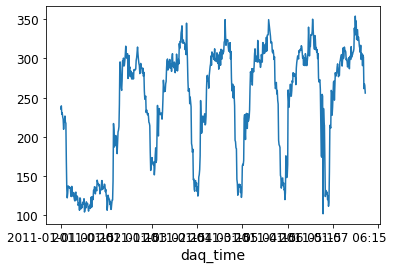

In [7]:
df_week = df.iloc[0:96*7]
df_week["power_usage"].plot()

In [8]:
series = df['power_usage'].values

### 데이터셋을 입력데이터와 타깃데이터로 분리하는 함수입니다.

In [9]:
def split_data_input_label(dataset, start_index, end_index, hist_data_size, target_size):
    data = []
    labels = []

    start_index = start_index + hist_data_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-hist_data_size, i)
        # Reshape data from (hist_data_size,) to (hist_data_size, 1)
        data.append(np.reshape(dataset[indices], (hist_data_size, 1)))
        labels.append([dataset[i+target_size]])
    return np.array(data), np.array(labels)

## 시계열 데이터를 정규화합니다.
 

* 상이한 스케일을 가진 값을 신경망에 주입하면 신경망 훈련이 어려우므로 데이터를 정규화합니다.
* 정규화 방법은 훈련데이터의 각 피처(feature)에서 평균을 빼고 각 피처의 표준편차로 나눕니다.
* 데이터 정규화를 통해 데이터의 평균은 0, 표준편차는 1인 데이터셋이 만들어집니다.
* 훈련 데이터 값만 이용하여 데이터를 정규화 합니다.


In [10]:
train_split = 70080 # 365일 * 2년 * 96개데이터
test_split = 105120 # 365일 * 3년 * 96개데이터

train_data_mean = series[:train_split].mean()
train_data_std = series[:train_split].std()
dataset = (series - train_data_mean)/train_data_std

## 훈련 데이터셋과 검증 데이터셋으로 데이터를 분할합니다.

In [11]:
n_steps = 20
future_target = 0

X_train, y_train = split_data_input_label(dataset, 0,train_split, 
                                          n_steps, 
                                          future_target)
X_valid, y_valid = split_data_input_label(dataset,train_split,test_split, 
                                          n_steps, 
                                          future_target)
X_test, _ = split_data_input_label(dataset, test_split, test_split+1000, 
                                   n_steps, 
                                   future_target)

In [12]:
X_train.shape

(70060, 20, 1)

## 입력데이터, 타깃데이터, 예측데이터를 그래프로 출력하는 함수입니다.

In [13]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, min(series) - abs(min(series)/10) , max(series) + abs(max(series)/10)])

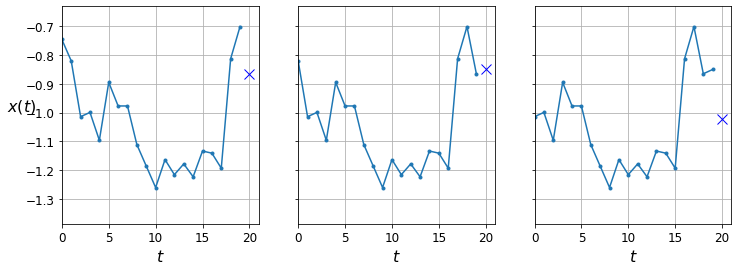

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## LSTM 모델 구성 

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(1)
])

모델 구성 확인

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 5,481
Trainable params: 5,481
Non-trainable params: 0
_________________________________________________________________


초기 가중치 설정 확인

In [17]:
hidden1 = model.layers[0]
hidden1.get_weights()

[array([[ 0.08957627, -0.03211184, -0.08008063, -0.01933324, -0.25384313,
          0.10052291,  0.13070339,  0.20273313, -0.14896908, -0.15067255,
         -0.10321166,  0.12102428, -0.19966762,  0.02616265,  0.04061189,
          0.21756014, -0.26701418,  0.01155654,  0.07323673, -0.16366494,
          0.12488177,  0.02494916, -0.21361428,  0.09618661,  0.08724338,
         -0.08875296,  0.05520478, -0.15751538,  0.19200581, -0.03232144,
          0.24414748, -0.14287278,  0.1697186 ,  0.01433736, -0.00309834,
         -0.1545201 ,  0.18818596,  0.20242807, -0.10430135,  0.10168311,
         -0.1428105 ,  0.15335047,  0.25427794, -0.2347691 ,  0.16261315,
          0.08724928,  0.04743916, -0.18255943,  0.12960649, -0.09768543,
          0.05845568, -0.01892379,  0.26020956,  0.12101269, -0.09609051,
          0.17732856, -0.00125659, -0.16610985,  0.14091358, -0.08815746,
         -0.11905575, -0.10062738,  0.05808514,  0.13600644,  0.00087392,
         -0.17265004, -0.20042372,  0.

모델 컴파일

In [18]:
model.compile(optimizer='adam', loss='mse')

모델 훈련 조기종료, 체크포인트 설정

In [19]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                    verbose=1, patience=5)
check_point = ModelCheckpoint('best_model.h5', verbose=1,
            monitor='val_loss', mode='min', save_best_only=True)

모델 컴파일

In [ ]:
history = model.fit(x=X_train, y=y_train, 
          epochs=50 , 
          batch_size=20,
          verbose=1,                                     
          validation_data=(X_valid, y_valid), 
          callbacks=[early_stop, check_point])

Epoch 1/50
3499/3503 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.02969, saving model to best_model.h5
3503/3503 [==============================] - 46s 13ms/step - loss: 0.0478 - accuracy: 0.0000e+00 - val_loss: 0.0297 - val_accuracy: 0.0000e+00
Epoch 2/50
3501/3503 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.0000e+00
Epoch 00002: val_loss did not improve from 0.02969
3503/3503 [==============================] - 45s 13ms/step - loss: 0.0335 - accuracy: 0.0000e+00 - val_loss: 0.0311 - val_accuracy: 0.0000e+00
Epoch 3/50
3502/3503 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.0000e+00
Epoch 00003: val_loss did not improve from 0.02969
3503/3503 [==============================] - 45s 13ms/step - loss: 0.0328 - accuracy: 0.0000e+00 - val_loss: 0.0301 - val_accuracy: 0.0000e+00
Epoch 4/50
3503/3503 [==============================] - ETA: 0s - loss: 0.0323 - 

신경망 모델의 학습상태를 출력하는 함수입니다.

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 검증 데이터셋으로 신경망 모델을 평가합니다.

In [ ]:
model.evaluate(X_valid, y_valid)

## 예측 결과를 확인합니다.

In [ ]:
start = 100
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
y_pred = model.predict(X_valid[start].reshape(1, 20, 1))
plot_series(X_valid[start, :, 0]*train_data_std+train_data_mean, 
            y_valid[start, 0]*train_data_std+train_data_mean, 
            y_pred[0, 0]*train_data_std+train_data_mean)

input_data = X_valid[start, :, 0]*train_data_std+train_data_mean
print("입력 데이터 : {}".format(np.round(input_data,2)))
predict_value = y_pred[0, 0]*train_data_std+train_data_mean
print("예측값 : {}".format(round(predict_value, 2)))
real_value = y_valid[start, 0]*train_data_std+train_data_mean
print("실제값 : {}".format(round(real_value)))
error = abs(predict_value-real_value)
error_rate = error/real_value*100
print("에러값 : {}".format(round(error, 2)))
print("에러율 : {}%".format(round(error_rate, 2)))

## 신경망 모델과 가중치 저장

In [ ]:
m_name = os.path.splitext(file_name)[0]
model_json = model.to_json()
with open(colab_dir + m_name + '.json', 'w') as f : 
    f.write(model_json)
model.save_weights(colab_dir + m_name + '.h5')
print("Save model to disk")

## 저장한 모델 불러오기

In [ ]:
json_file = open(colab_dir + m_name + '.json', 'r')
loaded_model_json = json_file.read() 
json_file.close()
simple_lstm_model = tf.keras.models.model_from_json(loaded_model_json)
simple_lstm_model.load_weights(colab_dir + m_name + '.h5')
print("Load model from disk")

## 저장한 모델을 사용하여 예측

In [ ]:
start = 100
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
y_pred = model.predict(X_valid[start].reshape(1, 20, 1))
plot_series(X_valid[start, :, 0]*train_data_std+train_data_mean, 
            y_valid[start, 0]*train_data_std+train_data_mean, 
            y_pred[0, 0]*train_data_std+train_data_mean)

input_data = X_valid[start, :, 0]*train_data_std+train_data_mean
print("입력 데이터 : {}".format(np.round(input_data,2)))
predict_value = y_pred[0, 0]*train_data_std+train_data_mean
print("예측값 : {}".format(round(predict_value, 2)))
real_value = y_valid[start, 0]*train_data_std+train_data_mean
print("실제값 : {}".format(round(real_value)))
error = abs(predict_value-real_value)
error_rate = error/real_value*100
print("에러값 : {}".format(round(error, 2)))
print("에러율 : {}%".format(round(error_rate, 2)))